##  数据描述

- uuid: 样本的 id
- eid : 访问行为 id
- udmap : 行为属性，为字典 {"key3":"67804"} 可能为 unknown, 或多个 key-value pair
- common_ts : 访问记录发生的事件 (毫秒)
- x1-x8 : 用户相关的属性
- target: 预测目标 0 / 1



## 一些笔记

### udmap 的形状? 

udmap 返回字符串，既有可能是长度不定的字典（不知道有几个key），也有可能是单一一个 `unknown` 没有对应的 key value

```{python}
print(train_data['udmap'][0]) 
# '{"key3":"67804","key2":"650"}'

print(train_data['udmap'][3]) 
# 'unknown'
```

### 如何转变为 one-hot 编码类型?

目标: 将这个 column 进行 one-hot 编码，如何进行?

1. 有dict的转换为dict，在把key对应列，value对应cell的数值
2. 没有dict的转换为0

第一步：判定输入是否为 `unknown`，通过简单的　`if 'unknown' in {row}` 可以查看, TRUE 就返回 0 ，False 就再细看

第二步：对字符串 `'{"key3":"67804","key2":"650"}'` 进行处理

1. 将字符串变为 dict ，示例用到的是 `eval` 他会返回字符串的表达内容。比如 `eval('2+2')` 返回 4，如果是 `print('2+2')` 返回的还是 '2+2' ，通过 `eval(train_data['udmap'][0])` 的方式将该字符串转为字典
2. 提取对应的 key-value pair

```{python}
for key,value in eval(train_data['udmap'][0]).items():
    print(key,value)

# key3 67804
# key2 650
```

以上，通过 for-loop 直接找 item 可以找到，但是并不是按我们想要的顺序, 可以通过

```{python}
d = eval(train_data['udmap'][0])
for i in range(1,10): # i from 1 to 9
    key = "key" + str(i) 
    # 创建 key -> 'key1' , 'key2', ...
    # 如果 'key1' 这个字符串在这个字典里，就提取出来
    if key in d:
        # 此时 d[key] 为该 key 对应的 value
        v[i-1] = d[key] # 将这个 value 赋值给对应的新的字典 v 
        # 反过来看，我们需要提前建立一个数组 v 按顺序接收对应的 value
```

改进版

```{Python}
d = eval(train_data['udmap'][0])
v = np.zeros(9) # 建立一个长度为9，数值均为0的数组
for i in range(1,10): # i from 1 to 9
    key = "key" + str(i) 
    # 创建 key -> 'key1' , 'key2', ...
    # 如果 'key1' 这个字符串在这个字典里，就提取出来
    if key in d:
        # 此时 d[key] 为该 key 对应的 value
        v[i-1] = d[key] # 将这个 value 赋值给对应的新的数组 , 如果没有key对应就还是0

```

这样，上式就将 `{"key3":2222}` 转变为了 `[0, 0, 2222, 0, 0, 0, 0, ...]` 的数组

**第三步**: 以上的每步都是基于行的操作，若想对整个dataframe 的行都进行如上操作

笨办法是通过 for-loop 循环index，然后 iloc 找位置的方法；也可以用 `df.apply(func)` 的方法一步执行，非常好用

**第四步**：对所有行都执行完会得到 n 维的数组，将这个 n 维数组一行一行累起来形成 dataframe 的操作？

`pd.DataFrame(np.vstack(df.Series.apply(func)))`

### 如何统计某一列的分布特征 (value_counts) 并将其 frequency 新增一列保存？

1. 统计frequency
2. 添加

#### value_counts()

`df.Series.value_counts()` 可以返回该 Series 对应的各个值的频率，通过 df.Series.map(df.Series.value_counts()) 可以得到对应的 freq

比如 `train_data['eid'].value_counts()` 的第一个是 26， 对应 frequency 是 174811，想要新建一列 `eid_freq` ，在 eid 为 26 的行，其对应的 eid_freq 应为 174811 

完成以上过程便可通过 `train_data['eid_freq'] = train_data['eid'].map(train_data['eid'].value_counts())` 实现

#### map() 函数

df.Series.map() 不仅可以接收 `value_counts()` 的结果，只要是 dictionary 也都能接收，此时 dictionary 的 key 应该和 `df.Series` 的值对应，dictionary 的 value 是新建列的数值



### 新增 feature ，判断 udmap 是否为 unknown 

`train_data['udmap_isunknown'] = (train_data['udmap'] == 'unknown').astype(int)`

将布尔序列 TRUE/FALSE转为1/0，TRUE就是1，FALSE就是0，如果是unknown就是1，不是就是0

### 训练

提取完特征之后就是基于 `sklearn.linear_model` 和 `sklearn.tree` 的 `DecisionTreeClassifier` 进行了训练

```{python}
clf = DecisionTreeClassifier()
clf.fit(
    train_data.drop(['udmap', 'common_ts', 'uuid', 'target'], axis=1),
    train_data['target']
)
```

## 可视化检查

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [140]:
train_data = pd.read_csv("../data/用户新增预测挑战赛公开数据/train.csv")
test_data = pd.read_csv("../data/用户新增预测挑战赛公开数据/test.csv")
train_data.head()

,uuid,eid,udmap,common_ts,x1,x2,x3,x4,x5,x6,x7,x8,target
0,0,26,"{""key3"":""67804"",""key2"":""650""}",1689673468244,4,0,41,107,206,1,0,1,0
1,1,26,"{""key3"":""67804"",""key2"":""484""}",1689082941469,4,0,41,24,283,4,8,1,0
2,2,8,unknown,1689407393040,4,0,41,71,288,4,7,1,0
3,3,11,unknown,1689467815688,1,3,41,17,366,1,6,1,0
4,4,26,"{""key3"":""67804"",""key2"":""650""}",1689491751442,0,3,41,92,383,4,8,1,0


### Correlation between features

In [141]:
# 只有 numeric 的数据能够计算 correlation 
# 默认是 pearson correlation
train_data.corr().abs()

,uuid,eid,common_ts,x1,x2,x3,x4,x5,x6,x7,x8,target
uuid,1.000000,0.000183,0.000628,0.001594,0.000107,0.001895,0.000778,0.000993,0.000065,0.000812,0.001145,0.000009
eid,0.000183,1.000000,0.058139,0.003157,0.044369,0.000949,0.012432,0.009791,0.028610,0.202015,0.347685,0.035941
common_ts,0.000628,0.058139,1.000000,0.020990,0.055021,0.014343,0.006625,0.004509,0.652145,0.071674,0.184667,0.053144
x1,0.001594,0.003157,0.020990,1.000000,0.027141,0.006335,0.003229,0.011904,0.032753,0.014764,0.031639,0.002941
x2,0.000107,0.044369,0.055021,0.027141,1.000000,0.016740,0.012860,0.020626,0.044131,0.082782,0.145542,0.027476
x3,0.001895,0.000949,0.014343,0.006335,0.016740,1.000000,0.004846,0.013763,0.012861,0.008993,0.003160,0.008969
x4,0.000778,0.012432,0.006625,0.003229,0.012860,0.004846,1.000000,0.070606,0.002889,0.021447,0.036651,0.010642
x5,0.000993,0.009791,0.004509,0.011904,0.020626,0.013763,0.070606,1.000000,0.010919,0.028954,0.028009,0.011677
x6,0.000065,0.028610,0.652145,0.032753,0.044131,0.012861,0.002889,0.010919,1.000000,0.249627,0.071505,0.028725
x7,0.000812,0.202015,0.071674,0.014764,0.082782,0.008993,0.021447,0.028954,0.249627,1.000000,0.616568,0.199992


<Axes: >

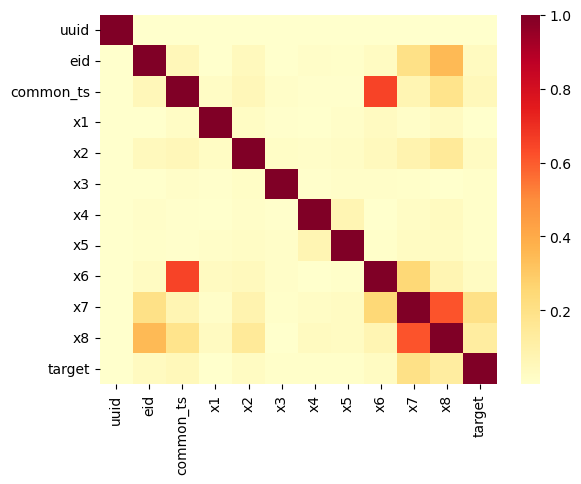

In [142]:
sns.heatmap(train_data.corr().abs(), cmap='YlOrRd')

# 以下几个pair之间似乎有相对高的相关性
# eid 和 x7,8
# common_ts 和 x6 
# x7,x8 

# 但是各个feature 和target 的关系可能不大

<Axes: xlabel='x7', ylabel='target'>

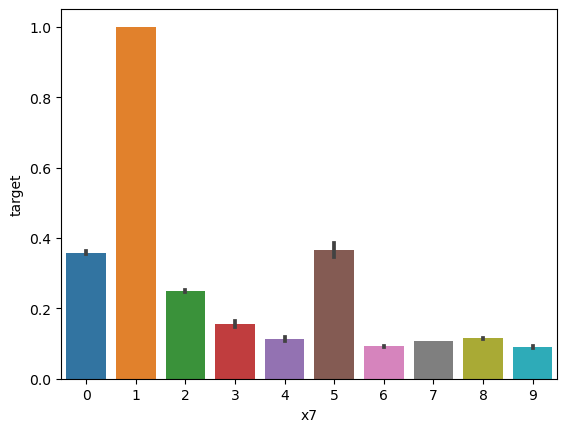

In [143]:
# x7分组下标签均值
sns.barplot(x='x7', y='target', data=train_data)

### 检查 x1 - x8 的特征

array([[<Axes: title={'center': 'x1'}>, <Axes: title={'center': 'x2'}>],
       [<Axes: title={'center': 'x3'}>, <Axes: title={'center': 'x4'}>],
       [<Axes: title={'center': 'x5'}>, <Axes: title={'center': 'x6'}>],
       [<Axes: title={'center': 'x7'}>, <Axes: title={'center': 'x8'}>]],
      dtype=object)

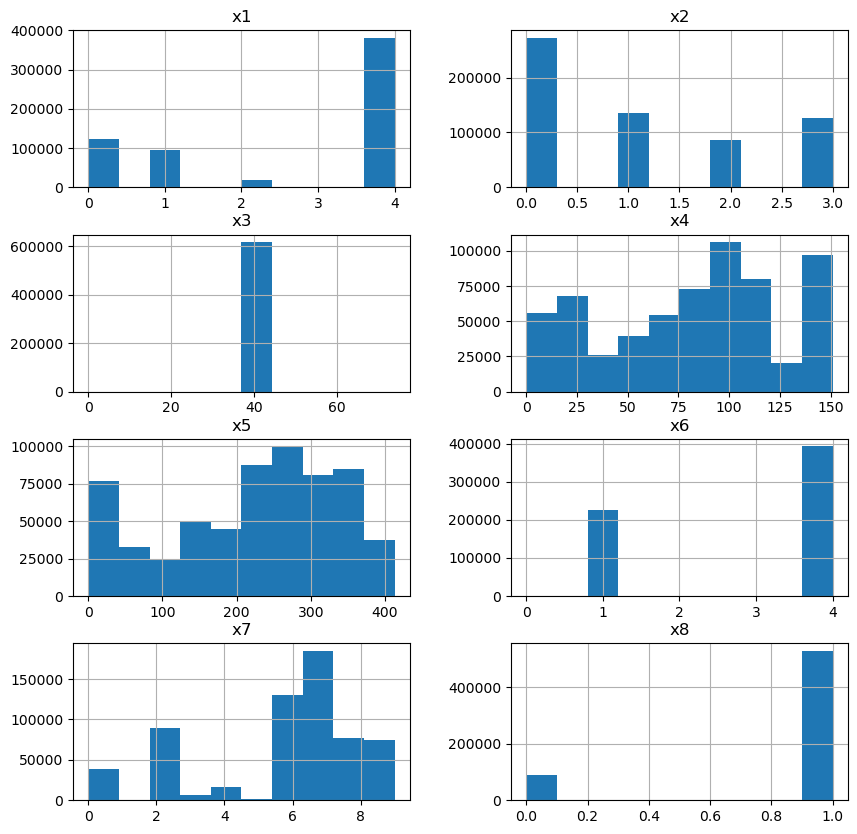

In [144]:
# x1, 2, 3, 6, 7, 8 应该是分类型变量
# x4, 5应该是数值型变量
train_data[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']].hist(layout=(4,2), figsize=(10,10))

比较不同 target 下 (0/1) x4, x5 这两个变量的分布特征 -> 好像没什么区别

<Axes: xlabel='target', ylabel='x4'>

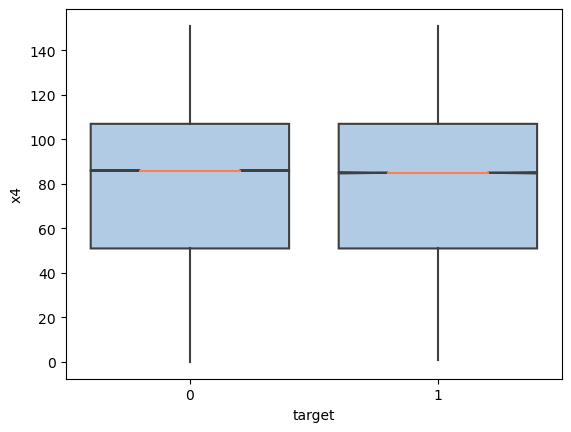

In [145]:
sns.boxplot(data=train_data, x="target", y="x4",
            notch=True, showcaps=False,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.4, .6, .8, .5)},
            medianprops={"color": "coral"}
)

<Axes: xlabel='target', ylabel='x5'>

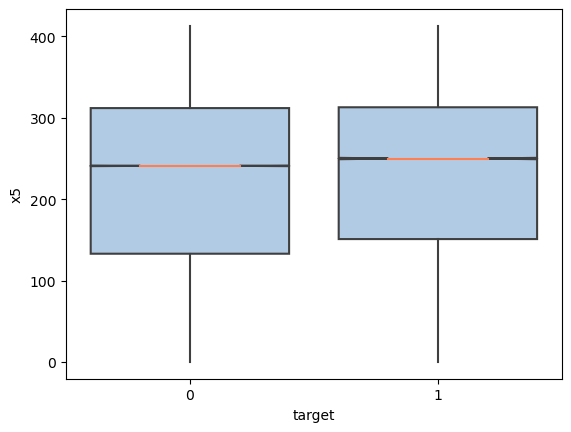

In [146]:
sns.boxplot(data=train_data, x="target", y="x5",
            notch=True, showcaps=False,
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.4, .6, .8, .5)},
            medianprops={"color": "coral"}
)

In [147]:
# 运行 `df.Series.dt.hour` 之前要先 pd.to_datetime(.., unit='ms') 才能正确执行，unit 要对应，不能瞎选
train_data['common_ts'] = pd.to_datetime(train_data['common_ts'], unit='ms')
train_data['common_ts_hour'] = train_data['common_ts'].dt.hour
train_data[['common_ts_hour', 'common_ts']].head()

,common_ts_hour,common_ts
0,9,2023-07-18 09:44:28.244
1,13,2023-07-11 13:42:21.469
2,7,2023-07-15 07:49:53.040
3,0,2023-07-16 00:36:55.688
4,7,2023-07-16 07:15:51.442


<Axes: xlabel='common_ts_hour', ylabel='target'>

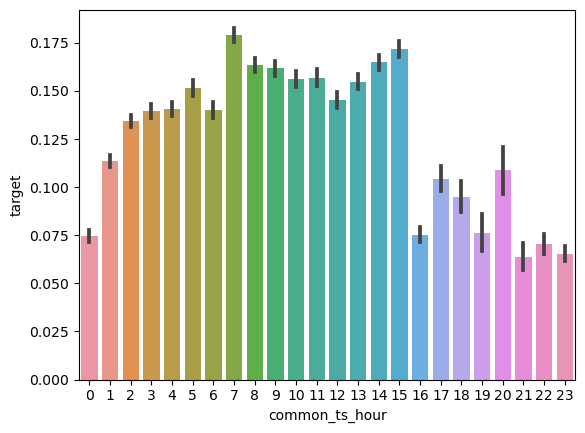

In [148]:
# common_ts_hour分组下标签均值
# 16 -> 0 小时的 target 值，特别是从 15-> 到16点，target下降非常明显
# target = 0 / 1 分别代表了什么? 是否为新增用户。
# 如果 1 == TRUE，0 == FALSE 的话，也就是 16h 至次日0点这个时间段，留下记录的人明显多为非新增用户？
sns.barplot(x='common_ts_hour', y='target', data=train_data)

### One hot encoding

In [149]:
def onehot(d):
    v = np.zeros(9)
    if d == 'unknown':
        return v
    
    else:
        d = eval(d)
        for i in range(1,10):
            key = 'key' + str(i)
            if key in d:
                v[i-1] = d[key]
        return v



In [150]:
train_udmap_key = train_data['udmap'].apply(onehot)

In [151]:
train_udmap_df = pd.DataFrame(np.vstack(train_udmap_key))

In [152]:
train_udmap_df.columns = ['key' + str(i) for i in range(1,10)]

In [153]:
train_merged = pd.concat([train_data, train_udmap_df], axis = 1)

In [154]:
train_merged

,uuid,eid,udmap,common_ts,x1,x2,x3,x4,x5,x6,...,common_ts_hour,key1,key2,key3,key4,key5,key6,key7,key8,key9
0,0,26,"{""key3"":""67804"",""key2"":""650""}",2023-07-18 09:44:28.244,4,0,41,107,206,1,...,9,0.0,650.0,67804.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,26,"{""key3"":""67804"",""key2"":""484""}",2023-07-11 13:42:21.469,4,0,41,24,283,4,...,13,0.0,484.0,67804.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,8,unknown,2023-07-15 07:49:53.040,4,0,41,71,288,4,...,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,11,unknown,2023-07-16 00:36:55.688,1,3,41,17,366,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,26,"{""key3"":""67804"",""key2"":""650""}",2023-07-16 07:15:51.442,0,3,41,92,383,4,...,7,0.0,650.0,67804.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620351,620351,2,"{""key4"":""14"",""key5"":""14""}",2023-07-10 12:07:30.527,4,0,41,104,37,4,...,12,0.0,0.0,0.0,14.0,14.0,0.0,0.0,0.0,0.0
620352,620352,8,unknown,2023-07-16 06:51:42.305,4,0,41,104,37,1,...,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
620353,620353,41,"{""key1"":""274"",""key2"":""446""}",2023-07-09 08:41:18.584,0,2,41,104,37,4,...,8,274.0,446.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
620354,620354,26,"{""key3"":""67804"",""key2"":""650""}",2023-07-18 04:02:40.171,4,0,41,17,366,1,...,4,0.0,650.0,67804.0,0.0,0.0,0.0,0.0,0.0,0.0


In [155]:
train_merged[['key1','key2','key3','key4','key5','key6','key7','key8', 'key9']].mean()

key1       64.216487
key2      260.316663
key3    29757.776830
key4        1.450109
key5        1.301670
key6        6.830705
key7        0.000588
key8        0.000140
key9        0.005660
dtype: float64

<Axes: >

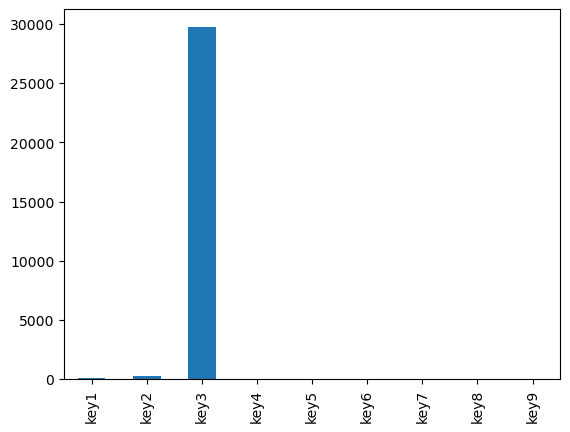

In [156]:
# 直接 plot 均值的话，key3 和其他值的差别太大了
train_merged[['key1','key2','key3','key4','key5','key6','key7','key8', 'key9']].mean().plot(kind='bar')


<Axes: >

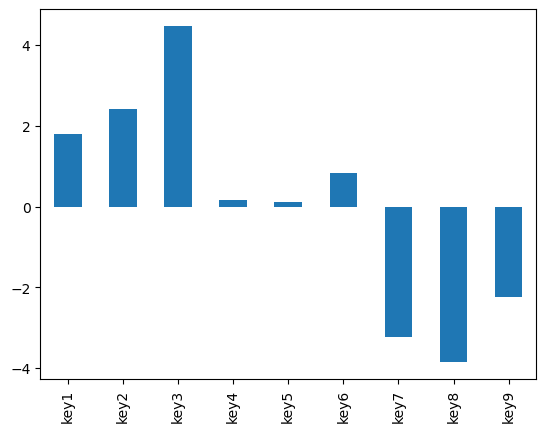

In [157]:
# 先通过 np.log10 求对数在 plot，相对更容易看一点
np.log10(train_merged[['key1','key2','key3','key4','key5','key6','key7','key8', 'key9']].mean()).plot(kind='bar')

<Axes: >

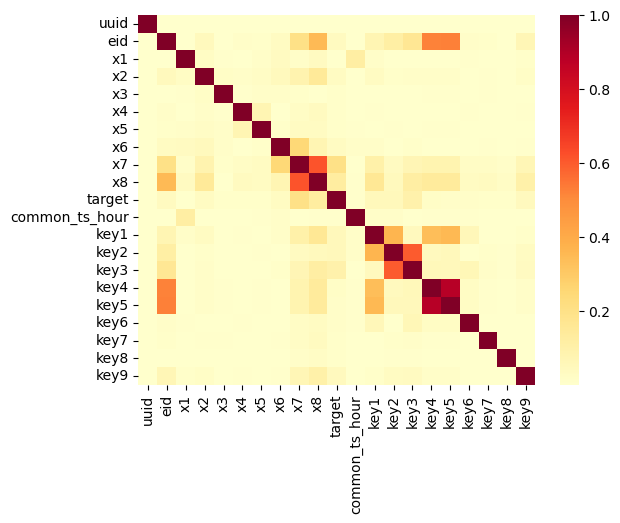

In [158]:
sns.heatmap(train_merged.corr().abs(), cmap='YlOrRd')

# eid () 和 x7, x8, key4, key 5 的关系可能比较明显
# x7,x8 ; key2,key3; key4,key5 之间的相关性比较强。。

In [159]:
train_merged.head()

,uuid,eid,udmap,common_ts,x1,x2,x3,x4,x5,x6,...,common_ts_hour,key1,key2,key3,key4,key5,key6,key7,key8,key9
0,0,26,"{""key3"":""67804"",""key2"":""650""}",2023-07-18 09:44:28.244,4,0,41,107,206,1,...,9,0.0,650.0,67804.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,26,"{""key3"":""67804"",""key2"":""484""}",2023-07-11 13:42:21.469,4,0,41,24,283,4,...,13,0.0,484.0,67804.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,8,unknown,2023-07-15 07:49:53.040,4,0,41,71,288,4,...,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,11,unknown,2023-07-16 00:36:55.688,1,3,41,17,366,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,26,"{""key3"":""67804"",""key2"":""650""}",2023-07-16 07:15:51.442,0,3,41,92,383,4,...,7,0.0,650.0,67804.0,0.0,0.0,0.0,0.0,0.0,0.0


## 小结

1. x4, x5 似乎是数值型变量，这两个变量的分布和 target 的分类关系好像不大
2. correlation heatmap 显示变量之间的相关性不是很强，这是个好事，至少一定程度上说明没有 variable 之间的 colinearity，但是这些变量和 target 的值关系不是很明显
3. common_ts 这个时间戳在转换格式后似乎和 target 更有关系了
4. 不同的 key , x1-x8 这些数值取值差异很大，后续需要 normalization，尽量减小巨大数字对模型的影响
